In [1]:
!pip install praw
!pip install vaderSentiment
!pip install ffn

     |████████████████████████████████| 167 kB 8.6 MB/s 
     |████████████████████████████████| 52 kB 2.0 MB/s 
     |████████████████████████████████| 125 kB 6.5 MB/s 


In [2]:
!pip install numerapi

In [3]:
import gc
import re
import csv
import json
import time
import datetime
import requests
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

import praw #reddit data api
import ffn #for loading financial data
import numerapi #for numerai tickers

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer #VADER sentiment model

In [4]:
%matplotlib inline

In [5]:
import tensorflow as tf
from tensorflow import keras
tf.test.gpu_device_name() #run to make sure tensorflow is connected to gpu (if applicable)

'/device:GPU:0'

# Data Collection

### Tickers we(Numerai) want

In [6]:
napi = numerapi.SignalsAPI()

eligible_tickers = pd.Series(napi.ticker_universe(), name="bloomberg_ticker")
print(f"Number of eligible tickers : {len(eligible_tickers)}")
print(eligible_tickers.head(10))

ticker_map = pd.read_csv(
        'https://numerai-signals-public-data.s3-us-west-2.amazonaws.com/signals_ticker_map_w_bbg.csv'
)
print(len(ticker_map))

#Yahoo <-> Bloomberg mapping
yfinance_tickers = eligible_tickers.map(
        dict(zip(ticker_map["bloomberg_ticker"], ticker_map["yahoo"]))
    ).dropna()

bloomberg_tickers = ticker_map["bloomberg_ticker"]
print(f"Number of eligible, mapped tickers: {len(yfinance_tickers)}")


Number of eligible tickers : 5359
0    SVW AU
1    GEM AU
2    AZJ AU
3    NXT AU
4    TWE AU
5    SGR AU
6    CKF AU
7    BGA AU
8    QUB AU
9    MMS AU
Name: bloomberg_ticker, dtype: object
5359
Number of eligible, mapped tickers: 5309


# positive/negative sentiment analysis using VADER

## get comments from reddit using pushshift and praw

In [ ]:
#function to get data from pushshift api
def getPushshiftData(query, after, before, sub):
    url = 'https://api.pushshift.io/reddit/search/submission/?title='+str(query)+'&size=1000&after='+str(after)+'&before='+str(before)+'&subreddit='+str(sub)
    print(url)
    r = requests.get(url)
    data = json.loads(r.text)
    return data['data']

#get relevant data from data extracted using previous function
def collectSubData(subm):
    subData = [subm['id'], subm['title'], subm['url'], datetime.datetime.fromtimestamp(subm['created_utc']).date()]
    try:
        flair = subm['link_flair_text']
    except KeyError:
        flair = "NaN"
    subData.append(flair)
    subStats.append(subData)

In [ ]:
a_date = "04/01/2015"
b_date = "28/02/2021"

In [ ]:
#Subreddit to query
sub='wallstreetbets'
#before and after dates
before = str(int(time.mktime(datetime.datetime.strptime(b_date, "%d/%m/%Y").timetuple()))) #july 10 2020
after = str(int(time.mktime(datetime.datetime.strptime(a_date, "%d/%m/%Y").timetuple()))) #july 1 2017
#query string
query = "Daily Discussion"
subCount = 0
subStats = []

In [ ]:
data = getPushshiftData(query, after, before, sub)
# Will run until all posts have been gathered 
# from the 'after' date up until before date
while len(data) > 0:
    for submission in data:
        collectSubData(submission)
        subCount+=1
    # Calls getPushshiftData() with the created date of the last submission
    print(len(data))
    print(str(datetime.datetime.fromtimestamp(data[-1]['created_utc'])))
    after = data[-1]['created_utc']
    try:
        data = getPushshiftData(query, after, before, sub)
    except Exception as e:
        print(e)

In [ ]:
#organize data into dataframe
data={}
ids=[]
titles=[]
urls=[]
dates=[]
flairs=[]
for stat in subStats:
    ids.append(stat[0])
    titles.append(stat[1])
    urls.append(stat[2])
    dates.append(stat[3])
    flairs.append(stat[4])
data['id']=ids
data['title']=titles
data['url']=urls
data['date']=dates
data['flair']=flairs
df_1=pd.DataFrame(data)
df_1=df_1[(df_1['flair']=='Daily Discussion')]

## Download data from Reddit using praw

[How to set-up PRAW](https://towardsdatascience.com/scraping-reddit-data-1c0af3040768)

In [ ]:
#connect to reddit api
reddit = praw.Reddit(client_id='XXXXXX',
                     client_secret='XXXXXXXX', 
                     user_agent='XXXXXXXXXXXXXX')

In [ ]:
#collect comments using praw
comments_by_day=[]
for url in tqdm(df_1['url'].tolist()):
    try:
        submission = reddit.submission(url=url)
        submission.comments.replace_more(limit=0)
        comments=list([(comment.body) for comment in submission.comments])
    except:
        comments=None
    comments_by_day.append(comments)

## Symbol filtering

Use some stop words that might create ambiguity with stock names in comments

In [ ]:
!wget https://gist.githubusercontent.com/ZohebAbai/513218c3468130eacff6481f424e4e64/raw/b70776f341a148293ff277afa0d0302c8c38f7e2/gist_stopwords.txt

gist_file = open("gist_stopwords.txt", "r")
try:
    content = gist_file.read()
    stop_words = content.split(",")
finally:
    gist_file.close()

In [ ]:
#Add more stop words that are used in the discussions
stop_words += ['ATH', 'SAVE', 'US', 'ALL', 'LOVE', 'FOR', 'ME', 
               'GET', "BEAT", 'JACK', "PUMP", "BIG", "KIDS", 'STAY', 
               'TRUE', 'EDIT','PLAY', "ROCK", "NICE", "DIE", "COST", 
               "WORK", "MF"]

- Remove stocks with only nubers as their mention will be next to none,

- Remove symbols with length smaller than 2 to reduce similarities between common English words.

In [7]:
filter_init = bloomberg_tickers#[bloomberg_tickers.apply(lambda x: (x.split(" ")[1] == "US") | (x.split(" ")[1] == "CA"))]
filter_init = filter_init.apply(lambda x: x.split(" ")[0])
ticks = filter_init[filter_init.str.len()>=2].values

2021-08-25 18:17:13,441 INFO numexpr.utils: NumExpr defaulting to 2 threads.


In [ ]:
ticks = [t for t in ticks if not str.isdigit(t)]
ticks = [t for t in ticks if t not in stop_words]

In [ ]:
"BB" in ticks

In [ ]:
#Assert tick is not in stop words
ticks_ = []
for tic in ticks:
    if tic.lower() not in stop_words:
        ticks_.append(tic)

ticks = ticks_

In [ ]:
np.intersect1d(ticks, [s.upper() for s in stop_words])

## **Idea is:**

1. Score all comments for a day based on sentiment

2. Log all tickers mentioned in those comments

3. Assign the daily sentiment to tickers involved

In [ ]:
## run vader sentiment analyzer

analyser = SentimentIntensityAnalyzer()

scores = [] #For entire market
daily_tick_sentiments = [] #array of dictionaries with daily ticker sentiments

for comments in tqdm(comments_by_day):
    sentiment_score = 0
    c_tickers = []
    ticks_sent = dict()          #daily sentiments for tickers
    for tick in ticks:
        ticks_sent[tick] = 0     #initializing with 0
    try:
        for comment in comments:

            ticks_in_comment = []    
            for tick in ticks:
                #Scanning for ticks mentioned in the comment
                if (" " + tick + " " in comment) and (tick.lower() not in stop_words):
                    ticks_in_comment.append(tick)

            comment_score = analyser.polarity_scores(comment)["compound"]  #general score

            for tick in ticks_in_comment:
                #updating the scores of comment to all ticks in the comment
                ticks_sent[tick] = comment_score + ticks_sent[tick]
            sentiment_score = sentiment_score + comment_score

        daily_tick_sentiments.append(ticks_sent) 
    except TypeError:
        sentiment_score = 0

    scores.append(sentiment_score)

df_1["sentiment score"] = scores

In [ ]:
daily_arr = []
for day in daily_tick_sentiments:
    daily_arr.append(pd.Series(day))

day_df = pd.concat(daily_arr, 1)
day_df.columns = df_1.date.values

In [ ]:
day_df

,2018-08-10,2018-08-15,2018-08-20,2018-08-23,2018-08-27,2018-08-28,2018-08-29,2018-09-03,2018-09-04,2018-09-05,2018-09-07,2018-09-10,2018-09-11,2018-09-12,2018-09-13,2018-09-14,2018-09-18,2018-09-20,2018-09-21,2018-09-24,2018-09-25,2018-09-26,2018-09-27,2018-09-28,2018-10-02,2018-10-03,2018-10-04,2018-10-05,2018-10-08,2018-10-09,2018-10-11,2018-10-12,2018-10-16,2018-10-17,2018-10-18,2018-10-19,2018-10-22,2018-10-23,2018-10-24,2018-10-25,...,2020-12-11,2020-12-14,2020-12-15,2020-12-16,2020-12-17,2020-12-21,2020-12-22,2020-12-31,2021-01-04,2021-01-04,2021-01-05,2021-01-06,2021-01-07,2021-01-08,2021-01-08,2021-01-11,2021-01-12,2021-01-12,2021-01-13,2021-01-15,2021-01-18,2021-01-20,2021-01-22,2021-01-26,2021-01-27,2021-01-28,2021-01-28,2021-01-28,2021-01-28,2021-01-29,2021-01-29,2021-01-29,2021-01-29,2021-01-29,2021-02-01,2021-02-01,2021-02-02,2021-02-02,2021-02-02,2021-02-03
1COV,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0000,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0
8TRA,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0000,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0
A2A,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0000,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0
AA,0.0,0.0,0.0,0.0,0.0,0.2023,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,-0.7213,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.871,0.0
AA/,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0000,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZUMZ,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0000,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0
ZUO,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.1511,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0000,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0
ZURN,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0000,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0
ZYXI,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [ ]:
#select 400 extreme symbols as theere are only a few symbols 
#that are discussed daily
top_up = day_df.sum(1).nlargest(200).index
top_down = day_df.sum(1).nsmallest(200).index

tickers = top_down.append(top_up)
tickers

Index(['LOW', 'DOW', 'CGC', 'TTWO', 'ING', 'TALK', 'PCG', 'EAT', 'MMS', 'LEG',
       ...
       'CLF', 'DRRX', 'BMW', 'VIAC', 'BRC', 'TSE', 'DOMO', 'MSCI', 'PGE',
       'PRO'],
      dtype='object', length=400)

1. Transpose, 
2. calculate rolling average
3. Transpose

In [ ]:
ps = day_df[day_df.columns[:]].T.rolling(window=14).sum().T #Rolling sum over all dates

ps = ps.iloc[:, -1] #Scores for yesterday
#ps = ps.iloc[:, -7:].sum(1) #This can also be used

#ps = ps[ps!=0] #Remove tickers with no 0 sentiment scores
ps = ps.loc[tickers] #Or choose specific tickers

In [ ]:
scores = ps.rank(pct=True).sort_values(ascending=False).reset_index()
scores.columns = ["bloomberg_ticker", "signal"]
scores

,bloomberg_ticker,signal
0,BB,1.00000
1,POST,0.99750
2,MC,0.99500
3,PLS,0.99250
4,REAL,0.99000
...,...,...
395,MSM,0.01250
396,FOLD,0.01000
397,SKY,0.00625
398,RIG,0.00625


map shortned symbols back to bloomberg symbols

In [ ]:
mapping = pd.Series(
    bloomberg_tickers.values, index=bloomberg_tickers.apply(lambda x: x.split(" ")[0])
)
scores["bloomberg_ticker"] = scores["bloomberg_ticker"].apply(
    lambda x: mapping[x] if type(mapping[x]) == str else mapping[x].values[0]
)
scores.set_index("bloomberg_ticker").to_csv("Signal_WSB_ema.csv", index=True)


In [ ]:
## merge with spy price and plot

spy=ffn.get('spy', start='2010-01-01')
spy_vals=[]
for date in tqdm(df_1['date'].astype(str).values):
    try:
        spy_vals.append(float(spy.loc[date]))
    except KeyError:
        spy_vals.append(None)
        
df_1['spy']=spy_vals

In [ ]:
df_1=df_1[['date','sentiment score','spy']]
df_1=df_1.set_index('date')
df_1=df_1[df_1['spy'].notna()]

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


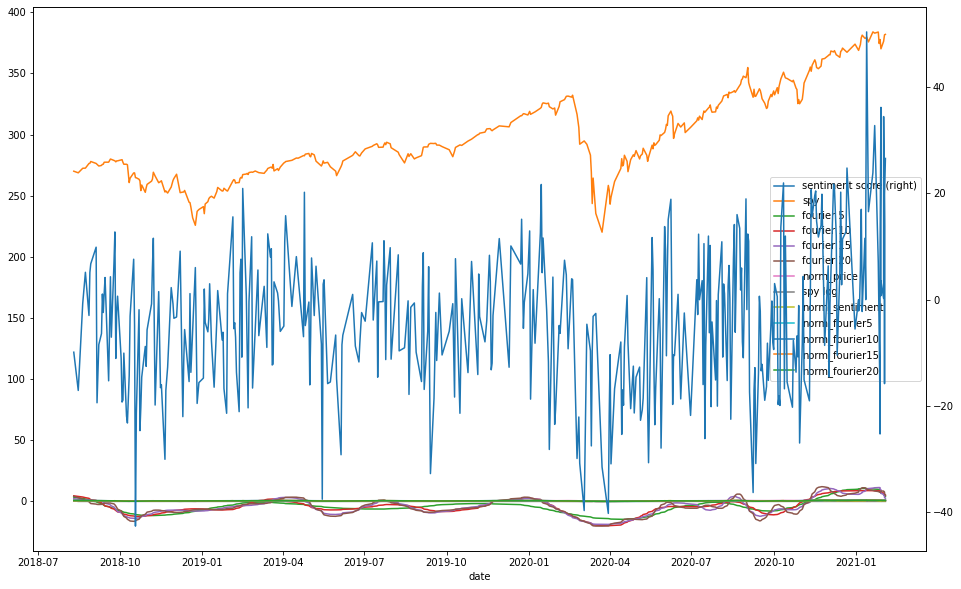

In [ ]:
df_1.plot(secondary_y='sentiment score', figsize=(16, 10))

In [ ]:
## fourier transform

close_fft = np.fft.fft(np.asarray(df_1['sentiment score'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
fft_list = np.asarray(fft_df['fft'].tolist())

for num_ in [5, 10, 15, 20]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    df_1['fourier '+str(num_)]=np.fft.ifft(fft_list_m10)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


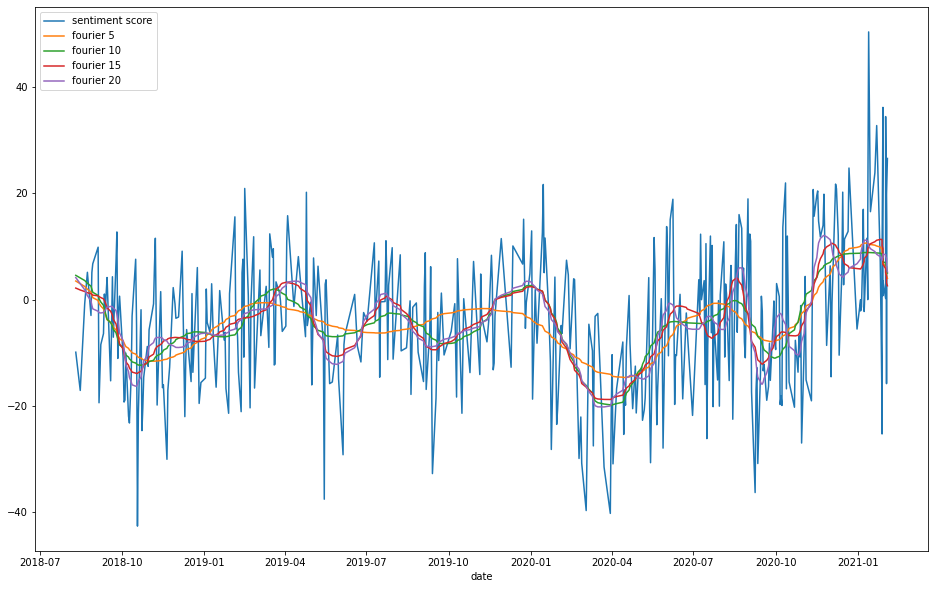

In [ ]:
df_1[['sentiment score', 'fourier 5', 'fourier 10', 'fourier 15', 'fourier 20']].plot(figsize=(16, 10))

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


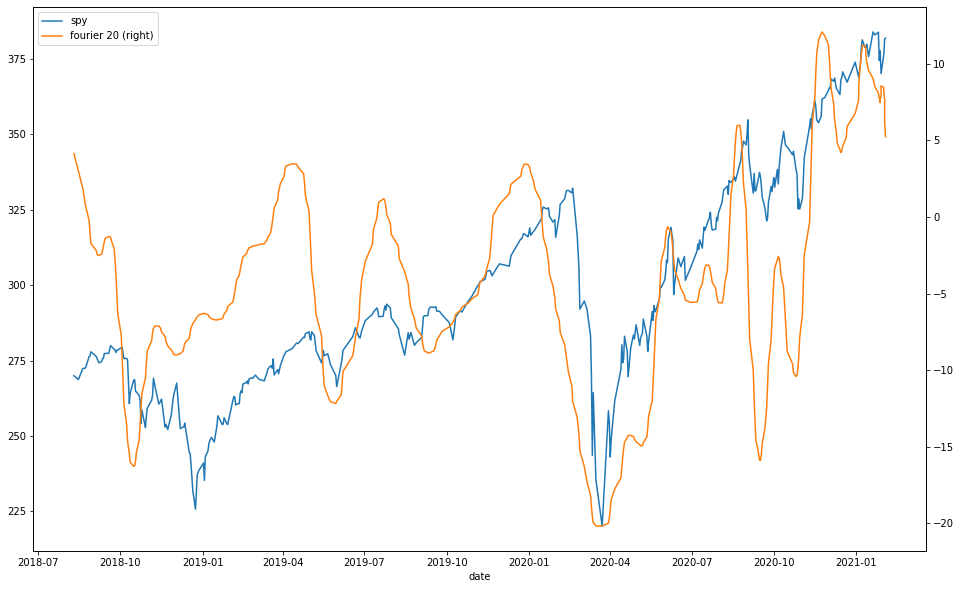

In [ ]:
df_1[['spy', 'fourier 20']].plot(secondary_y='fourier 20', figsize=(16, 10))

In [ ]:
#normalize
from sklearn.preprocessing import MinMaxScaler
sc= MinMaxScaler(feature_range=(0,1))
df_1['norm_price']=sc.fit_transform(df_1['spy'].to_numpy().reshape(-1, 1))
df_1['spy log']=np.log(df_1['spy']/df_1['spy'].shift(1))
df_1['norm_sentiment']=sc.fit_transform(df_1['sentiment score'].to_numpy().reshape(-1, 1))
df_1['norm_fourier5']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_1['fourier 5'].to_numpy()])).reshape(-1, 1))
df_1['norm_fourier10']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_1['fourier 10'].to_numpy()])).reshape(-1, 1))
df_1['norm_fourier15']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_1['fourier 15'].to_numpy()])).reshape(-1, 1))
df_1['norm_fourier20']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_1['fourier 20'].to_numpy()])).reshape(-1, 1))

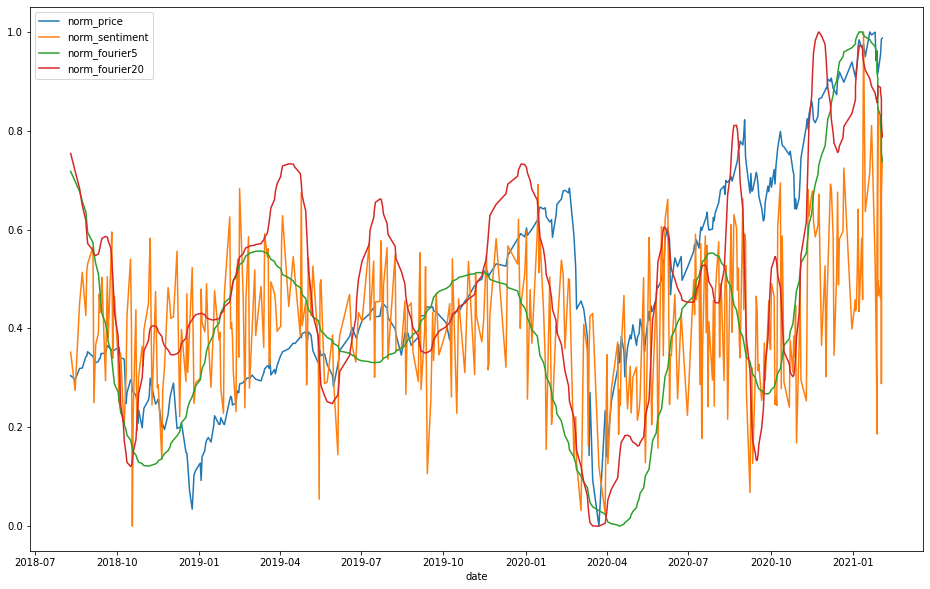

In [ ]:
df_1[['norm_price', 'norm_sentiment', 'norm_fourier5', 'norm_fourier20']].plot(figsize=(16, 10));

---

### This notebook is built upon the works of,

1.   [Can we actually predict market change by analyzing Reddit’s /r/wallstreetbets?](https://medium.com/the-innovation/can-we-actually-predict-market-change-by-analyzing-reddits-r-wallstreetbets-9d7716516c8e)
2.   [Sentiment Analysis for Trading with Reddit Text Data](https://medium.com/analytics-vidhya/sentiment-analysis-for-trading-with-reddit-text-data-73729c931d01)

